In [1]:
# 1. IMPOR PUSTAKA YANG DIBUTUHKAN
import os
# Baris ini harus ada SEBELUM import tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mengatur agar pesan log Python juga tidak terlalu ramai
import logging
tf.get_logger().setLevel(logging.ERROR)


# 2. PERSIAPAN DIREKTORI
print("🚀 Membuat direktori untuk Kasus B...")

# Membuat folder-folder untuk menyimpan semua hasil dari Kasus B
os.makedirs("saved_models_kasus_b", exist_ok=True)
os.makedirs("tflite_models_kasus_b_float", exist_ok=True)
os.makedirs("tflite_models_kasus_b_int8", exist_ok=True)
os.makedirs("headers_kasus_b_float", exist_ok=True)
os.makedirs("headers_kasus_b_int8", exist_ok=True)

print("✅ Direktori siap.")

🚀 Membuat direktori untuk Kasus B...
✅ Direktori siap.


In [3]:
# 3. PEMBUATAN DAN PEMBAGIAN DATA SINTETIS
print("🚀 Membuat data sintetis untuk fungsi y = 0.5x^2 + 2x - 1...")

# Parameter untuk generasi data
num_points = 1000

# Membuat 1000 titik data acak untuk x dalam rentang -10 hingga 10
np.random.seed(42) # Seed untuk hasil acak yang bisa direproduksi
x_all = np.random.uniform(-10.0, 10.0, num_points).astype(np.float32)

# Menghitung y berdasarkan fungsi non-linear
y_all = (0.5 * x_all**2) + (2 * x_all) - 1

# Reshape x dan y menjadi format yang dibutuhkan Keras (jumlah_sampel, 1 fitur)
x_all = x_all.reshape(-1, 1)
y_all = y_all.reshape(-1, 1)

# Mengacak data untuk menghilangkan bias urutan
indices = np.arange(x_all.shape[0])
np.random.shuffle(indices)

x_shuffled = x_all[indices]
y_shuffled = y_all[indices]

# Menggunakan pembagian 800/100/100
num_train = 800
num_val = 100

x_train = x_shuffled[:num_train]
y_train = y_shuffled[:num_train]

x_val = x_shuffled[num_train : num_train + num_val]
y_val = y_shuffled[num_train : num_train + num_val]

x_test = x_shuffled[num_train + num_val :]
y_test = y_shuffled[num_train + num_val :]

print("✅ Data berhasil dibuat dan dibagi:")
print(f"   Bentuk x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"   Bentuk x_val:   {x_val.shape}, y_val:   {y_val.shape}")
print(f"   Bentuk x_test:  {x_test.shape}, y_test:  {y_test.shape}")

🚀 Membuat data sintetis untuk fungsi y = 0.5x^2 + 2x - 1...
✅ Data berhasil dibuat dan dibagi:
   Bentuk x_train: (800, 1), y_train: (800, 1)
   Bentuk x_val:   (100, 1), y_val:   (100, 1)
   Bentuk x_test:  (100, 1), y_test:  (100, 1)


In [5]:
# Definisikan konfigurasi arsitektur dan EarlyStopping
model_configs = [(1, 8), (2, 16), (3, 32), (4, 64)]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True,
    verbose=0 
)

# List baru untuk menyimpan seluruh riwayat loss
all_train_loss_histories = []
all_val_loss_histories = []

# List untuk menyimpan hasil akhir
all_best_val_losses = []
all_test_losses = []
all_best_epochs = []
model_labels = []

print("\n🚀 Melatih, Mengevaluasi, dan Mengumpulkan Hasil untuk Kasus B (Non-Linear)...\n")

for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    print(f"--- Memproses Model {idx} ({num_layers}L, {neurons}N) ---")

    # Bagian Training (disesuaikan untuk input shape (1,) Kasus B Non-Linear)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(1,)))
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss='mean_squared_error'
    )
    
    history = model.fit(
        x_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Path penyimpanan disesuaikan
    model_path = f"saved_models_kasus_b/model_{idx}_layers_{num_layers}_neurons_{neurons}.keras"
    model.save(model_path)

    # --- Proses Pengumpulan Hasil ---

    # 1. Cari epoch terbaik dan kumpulkan loss-nya
    best_epoch_index = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_epoch_index]
    
    # Evaluasi pada data test yang benar
    test_loss = model.evaluate(x_test, y_test, verbose=0)
    
    # 2. Simpan riwayat loss HANYA SAMPAI epoch terbaik untuk plotting
    all_train_loss_histories.append(history.history['loss'][:best_epoch_index + 1])
    all_val_loss_histories.append(history.history['val_loss'][:best_epoch_index + 1])

    # 3. Simpan data ringkasan ke dalam list
    all_best_epochs.append(best_epoch_index + 1)
    all_best_val_losses.append(best_val_loss)
    all_test_losses.append(test_loss)
    model_labels.append(f"Model {idx}\n({num_layers}L, {neurons}N)")
    
    # 4. Tampilkan output yang rapi selama proses berjalan
    print(f"--- Hasil untuk Model {idx} ({num_layers}L, {neurons}N) ---")
    print(f"Epoch Terbaik: {best_epoch_index + 1} | Val Loss Terbaik: {best_val_loss:.6f} | Test Loss: {test_loss:.6f}")
    print("-" * 70)

# Tampilkan ringkasan akhir yang rapi
print("\n🏁 Pengumpulan Data Selesai. Ringkasan Hasil Akhir (Kasus B Non-Linear):\n")
for i in range(len(model_labels)):
    label_flat = model_labels[i].replace('\n', ' ')
    print(f"{label_flat}:")
    print(f"   Epoch Terbaik: {all_best_epochs[i]} | Val Loss Terbaik: {all_best_val_losses[i]:.6f} | Test Loss: {all_test_losses[i]:.6f}")


🚀 Melatih, Mengevaluasi, dan Mengumpulkan Hasil untuk Kasus B (Non-Linear)...

--- Memproses Model 1 (1L, 8N) ---
--- Hasil untuk Model 1 (1L, 8N) ---
Epoch Terbaik: 200 | Val Loss Terbaik: 11.278992 | Test Loss: 10.640655
----------------------------------------------------------------------
--- Memproses Model 2 (2L, 16N) ---
--- Hasil untuk Model 2 (2L, 16N) ---
Epoch Terbaik: 197 | Val Loss Terbaik: 0.040557 | Test Loss: 0.063237
----------------------------------------------------------------------
--- Memproses Model 3 (3L, 32N) ---
--- Hasil untuk Model 3 (3L, 32N) ---
Epoch Terbaik: 195 | Val Loss Terbaik: 0.002025 | Test Loss: 0.003147
----------------------------------------------------------------------
--- Memproses Model 4 (4L, 64N) ---
--- Hasil untuk Model 4 (4L, 64N) ---
Epoch Terbaik: 109 | Val Loss Terbaik: 0.002604 | Test Loss: 0.002802
----------------------------------------------------------------------

🏁 Pengumpulan Data Selesai. Ringkasan Hasil Akhir (Kasus B 


📊 Membuat visualisasi hasil pelatihan untuk Kasus B (Non-Linear)...



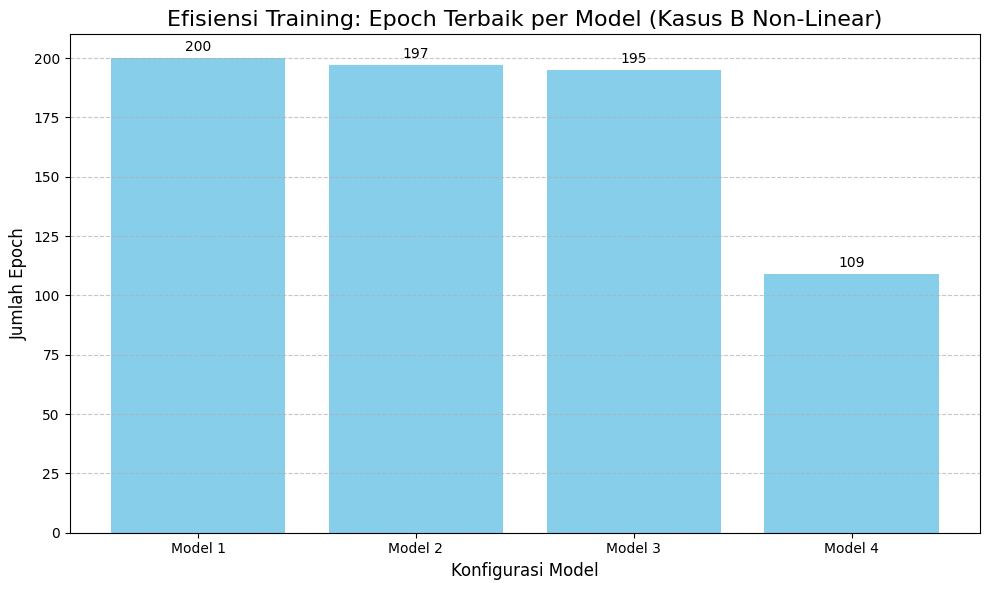

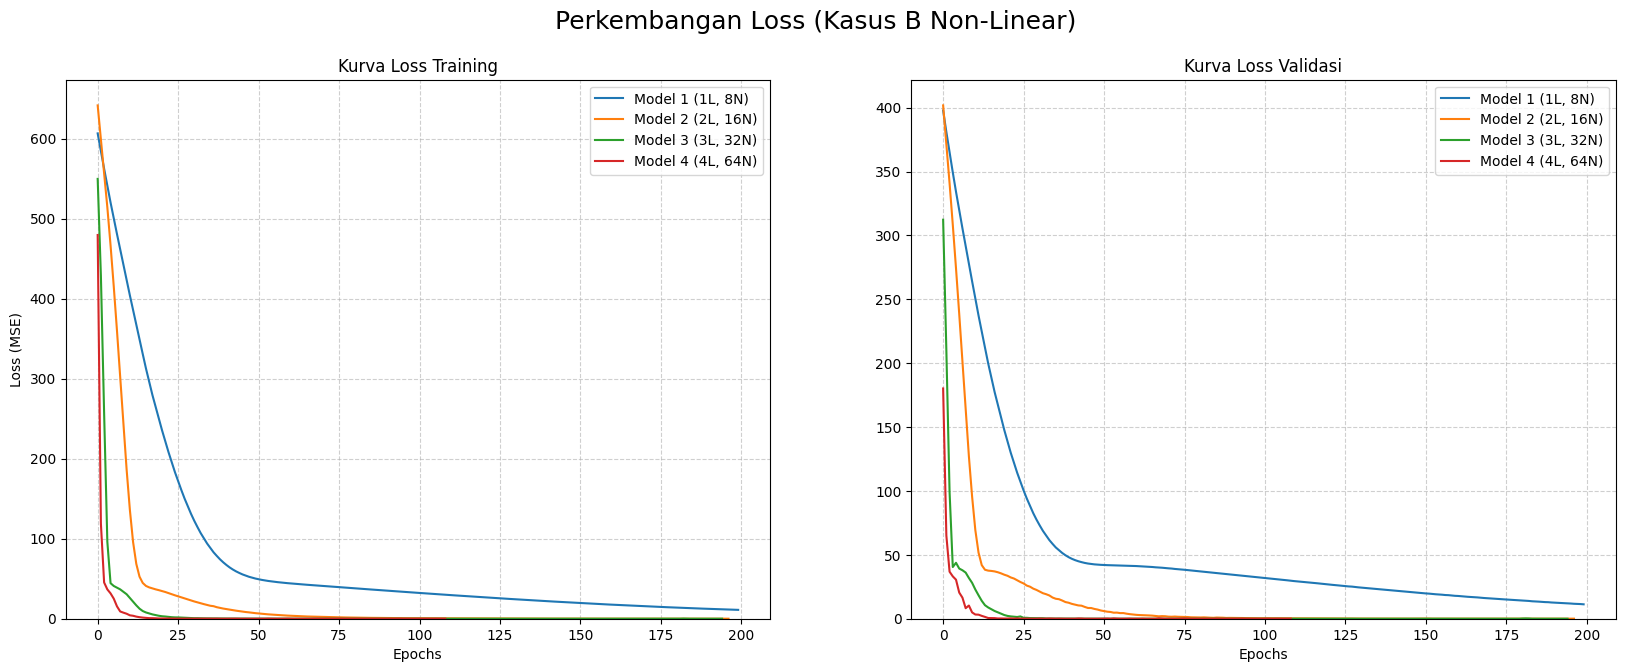

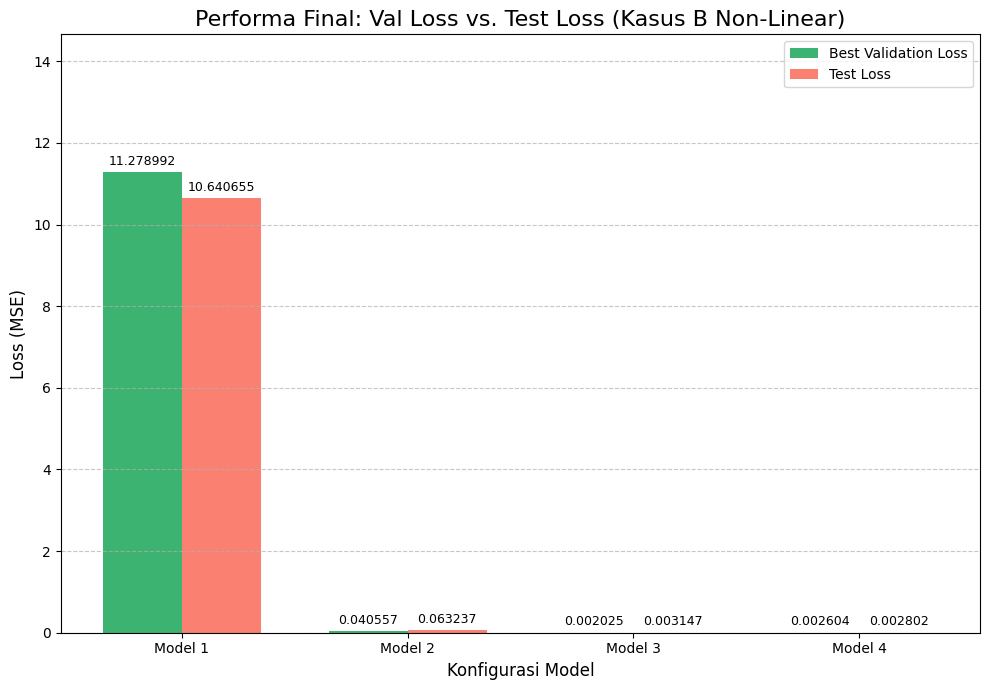

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


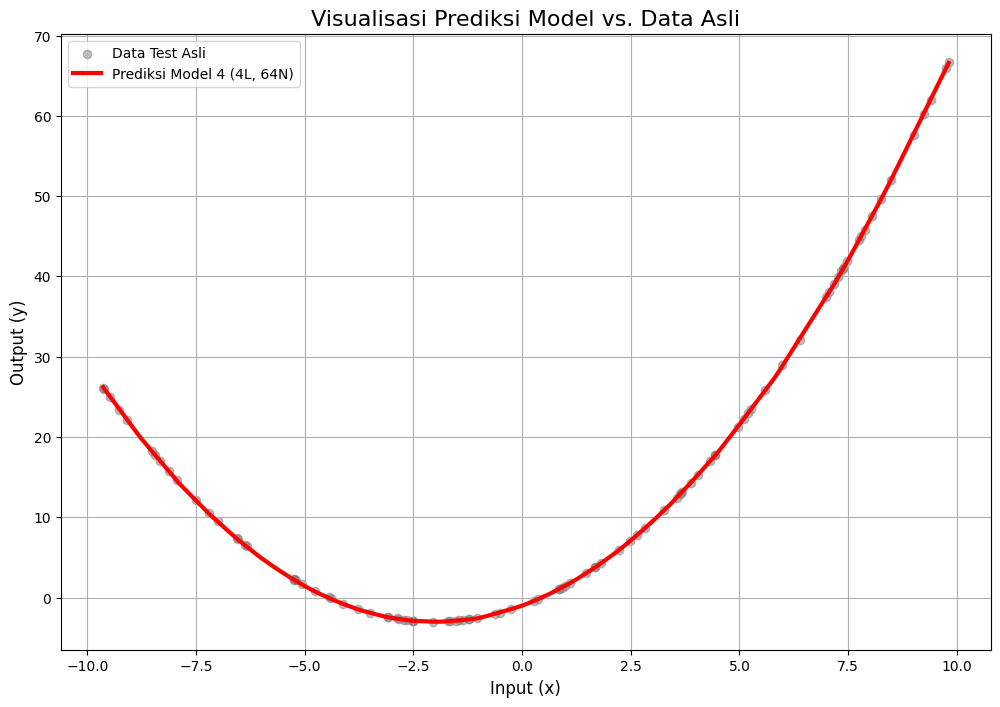

In [7]:
# Bagian ini dijalankan setelah Bagian 3 (Training) selesai

print("\n📊 Membuat visualisasi hasil pelatihan untuk Kasus B (Non-Linear)...\n")

# Buat label singkat untuk sumbu-x
short_labels = [f'Model {i+1}' for i in range(len(model_configs))]

# ================================================================
# Plot 1: Grafik Batang Epoch Terbaik
# ================================================================
plt.figure(figsize=(10, 6))
bars_epoch = plt.bar(short_labels, all_best_epochs, color='skyblue')
plt.title('Efisiensi Training: Epoch Terbaik per Model (Kasus B Non-Linear)', fontsize=16)
plt.ylabel('Jumlah Epoch', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar_label(bars_epoch, padding=3)
plt.tight_layout()
plt.show()


# ================================================================
# Plot 2 & 3: Kurva Loss Training dan Validasi
# ================================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Perkembangan Loss (Kasus B Non-Linear)', fontsize=18)
# Training Loss
for i, train_loss_history in enumerate(all_train_loss_histories):
    axes[0].plot(train_loss_history, label=model_labels[i].replace('\n', ' '))
axes[0].set_title('Kurva Loss Training')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_xlabel('Epochs')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()
axes[0].set_ylim(bottom=0)
# Validation Loss
for i, val_loss_history in enumerate(all_val_loss_histories):
    axes[1].plot(val_loss_history, label=model_labels[i].replace('\n', ' '))
axes[1].set_title('Kurva Loss Validasi')
axes[1].set_xlabel('Epochs')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()
axes[1].set_ylim(bottom=0)
plt.show()


# ================================================================
# Plot 4: Grafik Batang Test Loss vs. Val Loss
# ================================================================
plt.figure(figsize=(10, 7))
x_pos = np.arange(len(short_labels))
width = 0.35

rects1 = plt.bar(x_pos - width/2, all_best_val_losses, width, label='Best Validation Loss', color='mediumseagreen')
rects2 = plt.bar(x_pos + width/2, all_test_losses, width, label='Test Loss', color='salmon')

plt.title('Performa Final: Val Loss vs. Test Loss (Kasus B Non-Linear)', fontsize=16)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend()
plt.bar_label(rects1, padding=3, fmt='%.6f', fontsize=9)
plt.bar_label(rects2, padding=3, fmt='%.6f', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
max_loss_final = max(max(all_best_val_losses), max(all_test_losses))
if max_loss_final > 0:
    plt.ylim(0, max_loss_final * 1.3)
plt.tight_layout()
plt.show()


# ================================================================
# Plot 5: Perbandingan Prediksi Model dengan Data Asli
# ================================================================
# Kita akan gunakan model terbaik (misalnya model terakhir/paling kompleks) untuk plot ini
best_model_idx = len(model_configs) -1 # Ambil model ke-4
num_layers, neurons = model_configs[best_model_idx]
model_path = f"saved_models_kasus_b/model_{best_model_idx+1}_layers_{num_layers}_neurons_{neurons}.keras"
best_model = tf.keras.models.load_model(model_path)

# Buat data x yang urut untuk menghasilkan kurva prediksi yang mulus
x_plot = np.linspace(x_test.min(), x_test.max(), 200).reshape(-1, 1)
y_plot = best_model.predict(x_plot)

plt.figure(figsize=(12, 8))
# Tampilkan data uji asli sebagai titik-titik
plt.scatter(x_test, y_test, label='Data Test Asli', alpha=0.5, color='gray')
# Tampilkan prediksi model sebagai garis kurva
plt.plot(x_plot, y_plot, color='red', linewidth=3, label=f'Prediksi {model_labels[best_model_idx].replace("\n", " ")}')
plt.title('Visualisasi Prediksi Model vs. Data Asli', fontsize=16)
plt.xlabel('Input (x)', fontsize=12)
plt.ylabel('Output (y)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Bagian ini dijalankan setelah Bagian 2 (Persiapan Data)

print("\n🚀 Mengekspor keseluruhan data uji Kasus B (Non-Linear) ke format C array (.h)...")

#=============================================================================
# Konfigurasi Ekspor
#=============================================================================
# Nama file header yang akan dibuat
output_header_path = 'test_data_kasus_b.h'

# Mengambil seluruh data uji dari variabel yang sudah ada
x_test_to_export = x_test
y_test_to_export = y_test

# Mendapatkan parameter secara dinamis dari data
num_test_samples = len(x_test_to_export)
num_features = x_test_to_export.shape[1]

#=============================================================================
# Fungsi untuk memformat array NumPy menjadi string C
#=============================================================================
def format_array_to_c(array, var_name, var_type='float'):
    c_string = f"const {var_type} {var_name}[] = {{"
    flat_array = array.flatten()
    # Format angka dengan presisi untuk float
    formatted_values = [f"{val:.8f}f" for val in flat_array]
    c_string += ", ".join(formatted_values)
    c_string += "};"
    return c_string

#=============================================================================
# Proses Pembuatan File Header
#=============================================================================
# Format array fitur (x_test) menjadi string C
c_features_array = format_array_to_c(x_test_to_export, "test_features_b_nl", "float")

# Format array label (y_test) menjadi string C
c_labels_array = format_array_to_c(y_test_to_export, "test_labels_b_nl", "float")

# Gabungkan semua menjadi satu file header
header_content = f"""
// File ini berisi {num_test_samples} sampel data uji untuk Kasus B (Non-Linear)
// Fungsi: y = 0.5x^2 + 2x - 1
#ifndef TEST_DATA_KASUS_B_NONLINEAR_H
#define TEST_DATA_KASUS_B_NONLINEAR_H

const int TEST_SAMPLES_COUNT_B_NL = {num_test_samples};
const int FEATURES_PER_SAMPLE_B_NL = {num_features};

// Data Fitur Uji (x)
{c_features_array}

// Data Label Sebenarnya (y)
{c_labels_array}

#endif // TEST_DATA_KASUS_B_NONLINEAR_H
"""

# Tulis ke file .h
with open(output_header_path, 'w') as f:
    f.write(header_content)

print(f"✅ Data uji berhasil diekspor ke file C header: '{output_header_path}'")
print(f"   File tersebut berisi {num_test_samples} sampel data uji.")


🚀 Mengekspor keseluruhan data uji Kasus B (Non-Linear) ke format C array (.h)...
✅ Data uji berhasil diekspor ke file C header: 'test_data_kasus_b.h'
   File tersebut berisi 100 sampel data uji.


In [9]:
# Bagian ini dijalankan setelah Bagian 2 (Persiapan Data)

print("\n🚀 Membuat fungsi untuk representative dataset (Kasus B Non-Linear)...")

def representative_dataset_generator():
    """
    Generator yang menghasilkan sampel representatif untuk kalibrasi kuantisasi.
    Memastikan nilai ekstrem (min/max) dari rentang data disertakan.
    """
    # 1. Tentukan jumlah total sampel untuk kalibrasi
    num_samples = 200

    # 2. Ambil nilai ekstrem dari rentang data asli kita (-10 hingga 10)
    min_val = np.array([[-10.0]], dtype=np.float32)
    max_val = np.array([[10.0]], dtype=np.float32)

    # 3. Ambil sisa sampel secara acak dari data latih (x_train)
    num_random_samples = num_samples - 2
    
    random_indices = np.random.choice(
        np.arange(len(x_train)), 
        size=num_random_samples, 
        replace=False
    )
    random_samples = x_train[random_indices]

    # 4. Gabungkan nilai ekstrem dengan sampel acak
    combined_dataset = np.vstack([min_val, max_val, random_samples])

    # 5. Acak kembali gabungan dataset
    np.random.shuffle(combined_dataset)

    # 6. Gunakan 'yield' untuk memberikan satu per satu data
    for data in combined_dataset:
        # Data di-reshape menjadi (1, 1) sesuai input model dan dipastikan float32
        yield [data.astype(np.float32).reshape(1, 1)]

print("✅ Fungsi 'representative_dataset_generator' untuk Kasus B Non-Linear berhasil dibuat.")


🚀 Membuat fungsi untuk representative dataset (Kasus B Non-Linear)...
✅ Fungsi 'representative_dataset_generator' untuk Kasus B Non-Linear berhasil dibuat.


In [10]:
# Bagian ini dijalankan setelah Bagian 3 (Training) dan Bagian 6 (Generator)

print("\n🚀 Memulai proses konversi model ke format .tflite (Float32 & INT8)...")

# Loop melalui setiap konfigurasi model yang telah kita latih
for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    print(f"--- Mengonversi Model {idx} ({num_layers}L, {neurons}N) ---")
    
    # Path ke model Keras yang sudah disimpan (disesuaikan untuk Kasus B Non-Linear)
    keras_model_path = f"saved_models_kasus_b/model_{idx}_layers_{num_layers}_neurons_{neurons}.keras"
    model = tf.keras.models.load_model(keras_model_path)
    
    # --- Konversi ke TFLite Float32 (Standar) ---
    converter_float = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model_float = converter_float.convert()
    
    # Simpan file .tflite Float32 (disesuaikan untuk Kasus B Non-Linear)
    tflite_path_float = f"tflite_models_kasus_b_float/model_b_nl_{idx}_float.tflite"
    with open(tflite_path_float, "wb") as f:
        f.write(tflite_model_float)
    print(f"  ✅ Model Float32 disimpan di: {tflite_path_float}")

    # --- Konversi ke TFLite INT8 (Full Integer Quantization) ---
    converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_int8.representative_dataset = representative_dataset_generator
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_int8.inference_input_type = tf.int8
    converter_int8.inference_output_type = tf.int8
    converter_int8._experimental_disable_per_channel_quantization_for_dense_layers = True
    
    tflite_model_int8 = converter_int8.convert()
    
    # Simpan file .tflite INT8 (disesuaikan untuk Kasus B Non-Linear)
    tflite_path_int8 = f"tflite_models_kasus_b_int8/model_b_nl_{idx}_int8.tflite"
    with open(tflite_path_int8, "wb") as f:
        f.write(tflite_model_int8)
    print(f"  ✅ Model INT8 disimpan di: {tflite_path_int8}\n")

print("\n🏁 Semua model berhasil dikonversi ke format .tflite.")


🚀 Memulai proses konversi model ke format .tflite (Float32 & INT8)...
--- Mengonversi Model 1 (1L, 8N) ---
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmprzx9d57_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2306861253264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861252880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861254224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861254416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  ✅ Model Float32 disimpan di: tflite_models_kasus_b_float/model_b_nl_1_float.tflite
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpd13ogkmx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_1')
Output Ty

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


  ✅ Model INT8 disimpan di: tflite_models_kasus_b_int8/model_b_nl_1_int8.tflite

--- Mengonversi Model 2 (2L, 16N) ---
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpmpgefuvr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2306861265360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861266320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861266128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861267664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861267856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861268432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  ✅ Model Float32 disimpan di: tflite_models_kasus_b_float/model_b_nl_2_float.tflite
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmp0nf18a4r'. The following end

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmp216ycpzt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2306863770768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306863772304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306863772112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306863771536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861262480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861259408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306861264592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306863772688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  ✅ Model Float32 disimpan di: tflite_models_kasus_b_float/model_b_nl_3_float.tflite
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpz8y0xe8g'. 

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


  ✅ Model INT8 disimpan di: tflite_models_kasus_b_int8/model_b_nl_3_int8.tflite

--- Mengonversi Model 4 (4L, 64N) ---
Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpgyvpp6z7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2306864986064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864984912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864984720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864984336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864980496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864987408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864987600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864984144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2306864987792: TensorSpec(shape

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [12]:
# Bagian ini dijalankan setelah Bagian 7 (Konversi Model) selesai

print("\n🚀 Mengekstrak informasi kuantisasi dari setiap model INT8 Kasus B (Non-Linear)...\n")

# Loop melalui setiap model yang telah dikonversi ke INT8
for idx in range(1, len(model_configs) + 1):
    # Path disesuaikan untuk Kasus B Non-Linear
    quant_path = f"tflite_models_kasus_b_int8/model_b_nl_{idx}_int8.tflite"
    
    # Buat interpreter untuk membaca model
    interpreter = tf.lite.Interpreter(model_path=quant_path)
    interpreter.allocate_tensors()

    # Dapatkan detail dari tensor input dan output
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Cetak informasi kuantisasinya
    print("="*50)
    print(f"📦 Info Kuantisasi untuk Model {idx} (Kasus B Non-Linear)")
    print("="*50)
    print(f"🔹 Input scale      : {input_details['quantization'][0]}")
    print(f"🔹 Input zero point : {input_details['quantization'][1]}")
    print(f"🔹 Output scale     : {output_details['quantization'][0]}")
    print(f"🔹 Output zero point: {output_details['quantization'][1]}\n")

print("\n🏁 Ekstraksi Informasi Selesai.\n")


🚀 Mengekstrak informasi kuantisasi dari setiap model INT8 Kasus B (Non-Linear)...

📦 Info Kuantisasi untuk Model 1 (Kasus B Non-Linear)
🔹 Input scale      : 0.0784313753247261
🔹 Input zero point : -1
🔹 Output scale     : 0.23830443620681763
🔹 Output zero point: -122

📦 Info Kuantisasi untuk Model 2 (Kasus B Non-Linear)
🔹 Input scale      : 0.0784313753247261
🔹 Input zero point : -1
🔹 Output scale     : 0.27726295590400696
🔹 Output zero point: -117

📦 Info Kuantisasi untuk Model 3 (Kasus B Non-Linear)
🔹 Input scale      : 0.0784313753247261
🔹 Input zero point : -1
🔹 Output scale     : 0.28073540329933167
🔹 Output zero point: -117

📦 Info Kuantisasi untuk Model 4 (Kasus B Non-Linear)
🔹 Input scale      : 0.0784313753247261
🔹 Input zero point : -1
🔹 Output scale     : 0.2810456454753876
🔹 Output zero point: -117


🏁 Ekstraksi Informasi Selesai.




🚀 Memulai pembuatan header dan pengumpulan data ukuran model untuk Kasus B (Non-Linear)...

✅ Header FLOAT dibuat: headers_kasus_b_float/model_b_nl_1_float.h (1.56 KB)
✅ Header INT8 dibuat: headers_kasus_b_int8/model_b_nl_1_int8.h (1.80 KB)

✅ Header FLOAT dibuat: headers_kasus_b_float/model_b_nl_2_float.h (3.09 KB)
✅ Header INT8 dibuat: headers_kasus_b_int8/model_b_nl_2_int8.h (2.64 KB)

✅ Header FLOAT dibuat: headers_kasus_b_float/model_b_nl_3_float.h (10.86 KB)
✅ Header INT8 dibuat: headers_kasus_b_int8/model_b_nl_3_int8.h (5.15 KB)

✅ Header FLOAT dibuat: headers_kasus_b_float/model_b_nl_4_float.h (52.10 KB)
✅ Header INT8 dibuat: headers_kasus_b_int8/model_b_nl_4_int8.h (16.32 KB)


📊 Membuat plot perbandingan ukuran model...


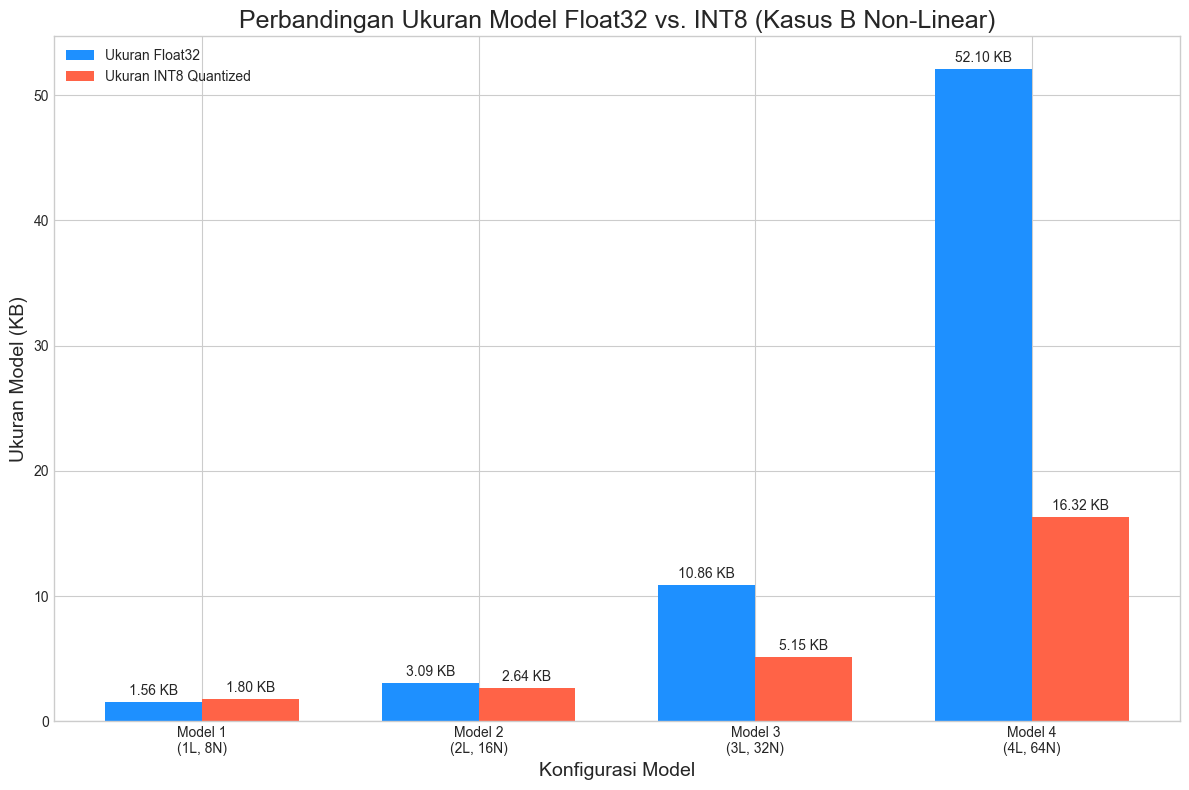


🏁 Alur kerja untuk Kasus B (Non-Linear) selesai.


In [13]:
# Bagian ini dijalankan setelah Bagian 7 (Konversi Model) selesai

# 9.1 FUNGSI UNTUK KONVERSI KE HEADER C++
def convert_to_header(tflite_model, filename, model_name, description=""):
    hex_array = ','.join(f'0x{b:02x}' for b in tflite_model)
    c_var_name = f"g_{model_name.lower().replace(' ', '_').replace('-', '_')}"
    header = f'''// File ini dibuat secara otomatis
#ifndef {c_var_name.upper()}_H
#define {c_var_name.upper()}_H

// Model: {model_name}
// {description}
// Size: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)
const unsigned char {c_var_name}_model_data[] = {{{hex_array}}};
const unsigned int {c_var_name}_model_data_len = {len(tflite_model)};

#endif // {c_var_name.upper()}_H
'''
    with open(filename, 'w') as f:
        f.write(header)

# 9.2 Inisialisasi list khusus untuk plot
model_labels_plot = []
float_sizes = []
int8_sizes = []

print("\n🚀 Memulai pembuatan header dan pengumpulan data ukuran model untuk Kasus B (Non-Linear)...\n")

# 9.3 Loop utama untuk membuat header dan mengumpulkan ukuran
for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    
    # Buat label untuk plot di dalam loop
    label = f"Model {idx}\n({num_layers}L, {neurons}N)"
    model_labels_plot.append(label)

    # --- PROSES FLOAT MODEL ---
    float_path = f"tflite_models_kasus_b_float/model_b_nl_{idx}_float.tflite"
    float_out = f"headers_kasus_b_float/model_b_nl_{idx}_float.h"
    model_name_f = f"Kasus B NL Model {idx} Float"
    desc_f = f"{num_layers}L, {neurons}N, float32"
    
    with open(float_path, "rb") as f:
        tflite_model_float = f.read()
    convert_to_header(tflite_model_float, float_out, model_name_f, desc_f)
    
    float_size_kb = len(tflite_model_float) / 1024
    float_sizes.append(float_size_kb)
    print(f"✅ Header FLOAT dibuat: {float_out} ({float_size_kb:.2f} KB)")

    # --- PROSES INT8 MODEL ---
    int8_path = f"tflite_models_kasus_b_int8/model_b_nl_{idx}_int8.tflite"
    int8_out = f"headers_kasus_b_int8/model_b_nl_{idx}_int8.h"
    model_name_q = f"Kasus B NL Model {idx} INT8"
    desc_q = f"{num_layers}L, {neurons}N, int8 quantized"

    with open(int8_path, "rb") as f:
        tflite_model_int8 = f.read()
    convert_to_header(tflite_model_int8, int8_out, model_name_q, desc_q)

    int8_size_kb = len(tflite_model_int8) / 1024
    int8_sizes.append(int8_size_kb)
    print(f"✅ Header INT8 dibuat: {int8_out} ({int8_size_kb:.2f} KB)\n")

# 9.4 Membuat plot perbandingan ukuran setelah loop selesai
print("\n📊 Membuat plot perbandingan ukuran model...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

x = np.arange(len(model_labels_plot))
width = 0.35

rects1 = plt.bar(x - width/2, float_sizes, width, label='Ukuran Float32', color='dodgerblue')
rects2 = plt.bar(x + width/2, int8_sizes, width, label='Ukuran INT8 Quantized', color='tomato')

plt.title('Perbandingan Ukuran Model Float32 vs. INT8 (Kasus B Non-Linear)', fontsize=18)
plt.ylabel('Ukuran Model (KB)', fontsize=14)
plt.xlabel('Konfigurasi Model', fontsize=14)
plt.xticks(x, model_labels_plot)
plt.legend()

plt.bar_label(rects1, padding=3, fmt='%.2f KB')
plt.bar_label(rects2, padding=3, fmt='%.2f KB')

plt.tight_layout()
plt.show()

print("\n🏁 Alur kerja untuk Kasus B (Non-Linear) selesai.")